In [1]:

import numpy as np
import glob
import pandas as pd

path = '/Users/rubythurs/Documents/dataProcess/ponEyes/'
#'C:/Users/ZHT/Documents/dataProcess/ponEyes'
files  = glob.glob(path + '/*.json') 
pon_eye=[]

for file in files:
    data = pd.read_json(file)
    data['SystemTimeStamp'] = pd.to_datetime(data['SystemTimeStamp'],unit='ms').astype(np.int64)
    data['SystemTimeStamp'] = data['SystemTimeStamp']/1000000
    filedata = {'filename':file, 'df':data}
    print(filedata['filename'])
    print(filedata['df'].shape)
    pon_eye.append(filedata)


/var/folders/9d/228cbhrj7gx34xplc04_qy100000gn/T/ipykernel_21917/3029068452.py:12: FutureWarning: casting datetime64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  data['SystemTimeStamp'] = pd.to_datetime(data['SystemTimeStamp'],unit='ms').astype(np.int64)


/Users/rubythurs/Documents/dataProcess/ponEyes/HY.json
(152794, 11)
/Users/rubythurs/Documents/dataProcess/ponEyes/Jia.json
(144793, 11)
/Users/rubythurs/Documents/dataProcess/ponEyes/Xiaochun.json
(183851, 11)
/Users/rubythurs/Documents/dataProcess/ponEyes/Ziyi.json
(166938, 11)
/Users/rubythurs/Documents/dataProcess/ponEyes/Lin.json
(187134, 11)


In [ ]:
import numpy as np
import glob
import pandas as pd

pathf = '/Users/rubythurs/Documents/dataProcess/ponFrame/'
#'C:/Users/ZHT/Documents/dataProcess/ponFrame'
files2  = glob.glob(pathf + '/*.json') 
pon_frame=[]

for file in files2:
    framedata = pd.read_json(file)
    framedata['timeStamp'] = pd.to_datetime(framedata['timeStamp'],unit='ms').astype(np.int64)
    framedata['timeStamp'] = framedata['timeStamp']/1000000
    framedata['Targetpos'] = framedata['targetpos2']
    framedata.drop(columns=['targetpos2'],inplace=True)
    filedata = {'filename':file, 'df':framedata}
    print(filedata['filename'])
    print(filedata['df'].shape)
    pon_frame.append(filedata)



In [ ]:

def splitXY(individual,Xi,colToSplit):
    newdf = pon_frame[individual]['df'].copy()

    # 分开多个标记点
    l = newdf[f'{colToSplit}'].apply(lambda x: len(x))
    splitlength  = l.max()
    print('length of splitCol:',splitlength)
    _list =[]
    for i in range(splitlength):
        _list.append(f'{colToSplit}{i+1}')

    points = newdf[f'{colToSplit}'].apply(lambda x: pd.Series(x))
    points.columns = _list
    newdf = pd.concat([newdf,points],axis=1)
    newdf= newdf.drop(columns=[f'{colToSplit}'])

    # 分开XY坐标
    for i in range(splitlength):
        b = newdf[f'{colToSplit}{i+1}'].apply(lambda x: pd.Series(x) if x else None)
        # ponPos 运行完有三列 targetpos 运行完有两列
        if (b.shape[1]>2):
            b = b.iloc[:,-2:]
        b.columns = [f'{colToSplit}{i+1}X',f'{colToSplit}{i+1}Y']
        newdf = pd.concat([newdf,b],axis=1)
        newdf= newdf.drop(columns=[f'{colToSplit}{i+1}'])
    return newdf



In [ ]:
#individual = 

def defineData(individual):
    df = pon_eye[individual]['df'].copy()
    data = df
    data.dropna(inplace=True)
    data['L_X'] = (data['LeftGazeX'] * 1920).round(0)
    data['L_Y'] = ((1-data['LeftGazeY'])*1080).round(0)
    data['SystemTimeStamp'] = data['SystemTimeStamp']
    data['R_X'] = (data['RightGazeX'] * 1920).round(0)
    data['R_Y'] = ((1-data['RightGazeY'])*1080).round(0)
    data.drop(columns=['LeftGazeX','LeftGazeY','RightGazeX','RightGazeY','Validity'], inplace=True)
    data['LeftPupilSize'] = data['LeftPupilSize'].round(2)
    data['RightPupilSize'] = data['RightPupilSize'].round(2)
    return data

def rawdata(individual):
    data = defineData(individual).copy()
    data = data[(data['L_X'] > 0) & (data['L_Y'] > 0) & (data['R_X'] > 0) & (data['R_Y'] > 0) & 
            (data['L_X'] < 1920) & (data['L_Y'] < 1080) &
            (data['R_X'] < 1920) & (data['R_Y'] < 1080)]
    return data

def savedata(filename,data):
    data.to_csv(f'{filename}', sep='\t', index=False,lineterminator='\n')


import matplotlib.pyplot as plt
def plotL(toplt):
    fig, ax = plt.subplots(1,1, figsize=(16,9))
    toplt['t'] = toplt['SystemTimeStamp']-min(toplt['SystemTimeStamp'])
    print('duration(ms): ',max(toplt['t']),'minLX(px): ', min(toplt['L_X']))
    ax.scatter(toplt['L_X'],toplt['L_Y'],s=0.1)



In [ ]:

def frameSegEye(individual):
    eyedf = pon_eye[individual]['df'].copy()
    eyedf = eyedf[eyedf['isGrey']== False]
    eyedf = rawdata(individual)

    # 提取用于分割trial的时间戳
    eyedfyest = eyedf['TrailTag'].shift(1)
    eyedf['equaltotyest'] = eyedf['TrailTag'] == eyedfyest
    eyelabel = eyedf['SystemTimeStamp'][eyedf['equaltotyest']==False]
    eyelabel = pd.DataFrame(eyelabel)
    eyelabel['label'] = 1
    eyelabel.reset_index(drop=False,inplace=True)
    #
    framedf = pon_frame[individual]['df'].copy()
    framedf = splitXY(individual,1,'ponPos')
    framedf2 = splitXY(individual,1,'targetpos')
    framedf2 = framedf2.drop(columns=['timeStamp'])
    framedf = pd.concat([framedf,framedf2],axis=1)
    # 
    framedf['SystemTimeStamp'] = framedf['timeStamp']
    framedf = pd.merge(how ='outer',right=framedf,left=eyelabel,on='SystemTimeStamp')
    framedf.drop(columns=['timeStamp'],inplace=True)
    framedf.sort_values(by='SystemTimeStamp',inplace=True,ascending=True)
    indexlabel = framedf[framedf['label']==1].index+1
    framelabel = pd.DataFrame(framedf.loc[indexlabel,'SystemTimeStamp'])
    framelabel.reset_index(drop=False,inplace=True)


    # 分别依据trial分割frame和eye
    frameSegement = []
    eyeSegement = []

    for i in range(0,len(framelabel)-1):
        #print(i,framelabel.loc[i,'index']) 
        a = framelabel.loc[i,'index']
        b = framelabel.loc[i+1,'index']
        data = framedf.loc[a:b]
        # 去掉看不见但是被记录的下一trial的marker位置
        if i>0:
            firstFrameindex = data.index.min()
            data = data[data['targetpos4X'] == data.loc[firstFrameindex,'targetpos4X']]
        frameSegement.append({'df':data,'ID':i+1})

    
    for i in range(0,len(eyelabel)-1):
        #print(i,eyelabel.loc[i,'index']) 
        a = eyelabel.loc[i,'index']
        b = eyelabel.loc[i+1,'index']
        data = eyedf.loc[a:b]
        eyeSegement.append({'df':data,'ID':i+1})

    return frameSegement,eyeSegement,framelabel


# Windows可以 Mac 不可以
individual=1
frameSegement,eyeSegement,framelabel = frameSegEye(individual)

In [ ]:
# MAC 适用
individual=2
framedf = splitXY(individual,1,'ponPos')
framedf2 = splitXY(individual,1,'targetpos')
print('framedf done seperate')
framedf2 = framedf2.drop(columns=['timeStamp'])
framedf = pd.concat([framedf,framedf2],axis=1)

framedf['SystemTimeStamp'] = framedf['timeStamp']
eyedf = rawdata(individual)
eyedf = eyedf[eyedf['isGrey']== False]
eyedfg = eyedf[eyedf['TrailTag']<=450]############ G G G G
eyedf = eyedfg.copy()
 # 提取用于分割trial的时间戳
eyedfyest = eyedf['TrailTag'].shift(1)
eyedf['equaltotyest'] = eyedf['TrailTag'] == eyedfyest
eyelabel = eyedf['SystemTimeStamp'][eyedf['equaltotyest']==False]
eyelabel = pd.DataFrame(eyelabel)
eyelabel['label'] = 1
eyelabel.reset_index(drop=False,inplace=True)
framedf = pd.merge(how ='outer',right=framedf,left=eyelabel,on='SystemTimeStamp')
framedf.drop(columns=['timeStamp'],inplace=True)
framedf.sort_values(by='SystemTimeStamp',inplace=True,ascending=True)
indexlabel = framedf[framedf['label']==1].index+1
framelabel = pd.DataFrame(framedf.loc[indexlabel,'SystemTimeStamp'])
framelabel.reset_index(drop=False,inplace=True)


frameSegement = []
for i in range(0,len(framelabel)-2):
    #print(i,framelabel.loc[i,'index']) 
    a = framelabel.loc[i,'index']
    b = framelabel.loc[i+1,'index']
    data = framedf.loc[a:b]

    if i>0:
        firstFrameindex = data.index.min()
        data = data[data['targetpos4X'] == data.loc[firstFrameindex,'targetpos4X']]
    frameSegement.append({'df':data,'ID':i+1})

eyeSegement = []
for i in range(0,len(eyelabel)-1):
     #print(i,eyelabel.loc[i,'index']) 
    a = eyelabel.loc[i,'index']
    b = eyelabel.loc[i+1,'index']
    data = eyedf.loc[a:b]
    eyeSegement.append({'df':data,'ID':i+1})
    
ex = []
ey = []
for i in range(0,len(eyeSegement)):
    x=eyeSegement[i]['df']['L_X']
    y=eyeSegement[i]['df']['L_Y']
    ex.append(x)
    ey.append(y)

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import os
os.environ["OMP_NUM_THREADS"] = '1'

s=[]
for i in range(0,len(eyeSegement)):
    e = list(zip(ex[i],ey[i]))
    kmeans = KMeans(n_clusters=3).fit(e)
    s .append( silhouette_score(e,kmeans.labels_))



plt.axvline(x=np.median(s),color='green',linestyle='--')
plt.axvline(x=np.mean(s),color='r',linestyle='--')
plt.text(np.median(s), 38, f'{np.median(s):.2f}', ha='center', va='bottom')
plt.text(np.mean(s), 35, f'{np.mean(s):.2f}', ha='center', va='bottom')
plt.title(f'Silhouette Score_{individual}')
plt.xlim(0,1)
plt.ylim(0,40)
plt.hist(s,bins=50)
leyepd = pd.DataFrame(eyeSegement)
leyepd.to_csv(f'leyeSeg_{individual}_g0.csv')

In [ ]:
pupil = []
for i in range(0,len(eyeSegement)-1):
    e =eyeSegement[i]['df'].copy()
    e = e.drop(e.tail(5).index,inplace=False)
    Lp=e['LeftPupilSize'].to_frame()
    Rp = e['RightPupilSize'].to_frame()
    tini = e['SystemTimeStamp'].min()
    tend = e['SystemTimeStamp'].max()
    e['t'] = e['SystemTimeStamp']-tini 
    e['process'] = e['t']/(tend-tini)
    t = e['t'].round(0).to_frame()
    p=e['process'].round(2).to_frame()
    t = pd.merge(t,p,on=t.index).drop(columns='key_0')
    _pupil = pd.merge(Lp,t,on=Lp.index)
    pupil_ = pd.merge(Rp,t,on=Rp.index)
    pupil.append([_pupil,pupil_])


In [ ]:
largeLP = []
for i in range(0,len(pupil)-1):
    lp = pupil[i][0].sort_values(by='LeftPupilSize',inplace=False,ascending=False)
    largeLP.append(lp.head(5))
largeLP[9]

In [ ]:
fig,ax = plt.subplots()
for i in range(0,len(largeLP)-1):
    x=largeLP[i]['process']
    i_ = [i]*len(x)
    ax.scatter(x,i_,c = 'grey',s=2)
    ax.set_xlim(0,1)
    ax.set_xlabel('Percentage of the trial ongoing')
    ax.set_ylabel('Trial number')
    ax.set_title(f'Largest Pupil Size Show-up Time_g98_{individual}')

In [ ]:

import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

klist = []
# Load your dataset
for i in range(0, len(ex)):
   e = list(zip(ex[i],ey[i]))
   X = e 
   
   # Define the range of clustering parameters (K)
   K_range = range(2, 11)

   # Initialize lists to store CH scores and K values
   ch_scores = []
   k_values = []
   #fig, ax = plt.subplots(1,2, figsize=(15, 5))


   # Perform clustering and calculate CH score for each K
   for k in K_range:
       kmeans = KMeans(n_clusters=k)
       kmeans.fit(X)
       ch_score = silhouette_score(X, kmeans.labels_)
       ch_scores.append(ch_score)
       k_values.append(k)

    # Plot the CH scores
   #ax[0].plot(k_values, ch_scores)
   #ax[0].set_xlabel('Number of clusters (K)')
   #ax[0].set_ylabel('CH score')
   #ax[0].set_title(f'CH score vs. K_{individual}')
   #ax[0].set_xlim(1, 10)
   #ax[0].set_ylim(0.4, 1)
   #x,y = zip(*X)
   #kmeans = KMeans(n_clusters=3).fit(X)
   #ax[1].scatter(x, y,c = kmeans.labels_)
   #ax[1].set_xlim(0,1920)
   #ax[1].set_ylim(0,1080)

   #plt.show()

   # Identify the optimal K value
   optimal_k = k_values[np.argmax(ch_scores)]
   klist.append(optimal_k)

In [ ]:
set_ = set(klist)
import collections
counter = collections.Counter(klist)
counter = pd.DataFrame(counter.items(), columns=['K', 'Count'])
counter = counter.sort_values(by='K', ascending=True)
counter

In [ ]:
k2=[]
k3=[]
for i,item in enumerate(klist):
    if item == 2:
        k2.append(i)
    if item == 3:
        k3.append(i)
k2Trial = []
for i in range(0,len(k2)):
    index = k2[i]
    a = eyeSegement[index]['df']['TrailTag']
    aa = list(a)[0]
    k2Trial.append(aa)
k3Trial = []
for i in range(0,len(k3)):
    index = k3[i]
    a = eyeSegement[index]['df']['TrailTag']
    aa = list(a)[0]
    k3Trial.append(aa)

import csv

with open(f'k2_{individual}.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(k2)
with open(f'k3_{individual}.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(k3)

In [ ]:

for i in range(0,len(eyeSegement)):
    e = list(zip(ex[i],ey[i]))
    kmeans = KMeans(n_clusters=3).fit(e)
    plt.scatter(ex[i], ey[i],c=kmeans.labels_)

    plt.xlim(0,1920)
    plt.ylim(0,1080)
    plt.show()


/var/folders/9d/228cbhrj7gx34xplc04_qy100000gn/T/ipykernel_21917/2139188381.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_diff['SystemTimeStamp'] = df_diff['SystemTimeStamp'] - tmin


Text(0, 0.5, 'Pupil Size(cm)')

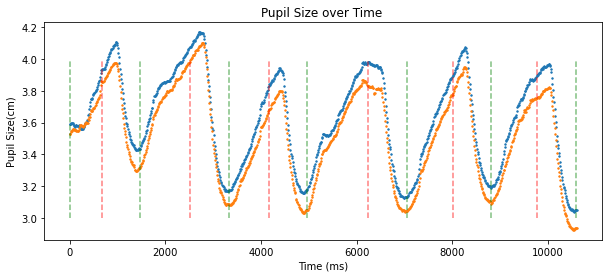

In [73]:
import matplotlib.pyplot as plt

individual = 0
df = pon_eye[individual]['df']

df = df[(df['TrailTag'] <= 7) & (df['TrailTag'] >=2)]
l = df['LeftPupilSize']
r = df['RightPupilSize']
tmin = df['SystemTimeStamp'].min()
t = df['SystemTimeStamp'] - tmin
fig,ax = plt.subplots(figsize=(10,4))
ax.scatter(t,l,s=2)
ax.scatter(t,r,s=2)
df_diff = df[df['isGrey'].ne(df['isGrey'].shift(1))]
df_diff['SystemTimeStamp'] = df_diff['SystemTimeStamp'] - tmin
ax.vlines(df_diff[df_diff['isGrey'] == False]['SystemTimeStamp'],3,4,linestyles='--',color='green',alpha=0.5)
ax.vlines(df_diff[df_diff['isGrey'] == True]['SystemTimeStamp'],3,4,linestyles='--',color='red',alpha=0.5)
ax.set_title(f'Pupil Size over Time ')
ax.set_xlabel('Time (ms)')
ax.set_ylabel('Pupil Size(cm)')

Text(0, 0.5, 'Pupil Dilation Speed (cm/s)')

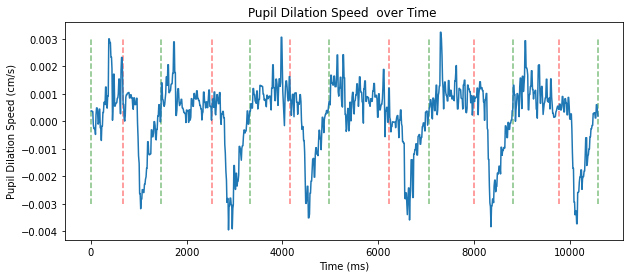

In [95]:

individual = 0
df = pon_eye[individual]['df']
df = df[(df['TrailTag'] <= 7) & (df['TrailTag'] >=2)]

l = df['LeftPupilSize']
l = list(l)
r = df['RightPupilSize']
r = list(r)
tmin = df['SystemTimeStamp'].min()
t = df['SystemTimeStamp'] - tmin
t = list(t)
d = []
dr = []
for i in range(1, len(df)-2):
    d_ = max((l[i]-l[i-1])/(t[i]-t[i-1]), (l[i+1]-l[i])/(t[i+1]-t[i]))
    d__ = max((r[i]-r[i-1])/(t[i]-t[i-1]), (r[i+1]-r[i])/(t[i+1]-t[i]))
    d.append(d_)
    dr.append(d__)
fig,ax = plt.subplots(figsize=(10,4))
ax.plot(t[1:-2],d)
ax.vlines(df_diff[df_diff['isGrey'] == False]['SystemTimeStamp'],-0.003,0.003,linestyles='--',color='green',alpha=0.5)
ax.vlines(df_diff[df_diff['isGrey'] == True]['SystemTimeStamp'],-0.003,0.003,linestyles='--',color='red',alpha=0.5)
ax.set_title(f'Pupil Dilation Speed  over Time ')
ax.set_xlabel('Time (ms)')
ax.set_ylabel('Pupil Dilation Speed (cm/s)')

In [ ]:
import ipywidgets as widgets
import plotly.graph_objects as go
import plotly.express as px

# make a control widget
w = widgets.IntSlider(
    min = 0,
    max = framelabel.index.max()-1,
    step = 1,
    description='segID:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d'
)
button = widgets.Button(
    description='Next',
    )

def on_button_clicked(b):
    button.disabled = True
    w.value += 1
    button.disabled = False
button.on_click(on_button_clicked)


def scatter(xvalue,yvalue,tracename,mode='markers',color= 'MediumPurple',size= 10,symbol='circle'):
   x = xvalue
   y = yvalue
   trace = go.Scatter(x=x,y=y,
                    name=tracename,
                    mode=mode,
                    #size= size,
                    marker=dict(color=color,
                                size=size,
                                line = dict(width=0.5,color=color),
                                symbol=symbol)
                    )  
   return trace

def updatascatter(xupdate,yupdate,fig,tracelabel):
    if xupdate is not None:
        fig.data[tracelabel].x = xupdate
        fig.data[tracelabel].y = yupdate
    fig.layout.title.text = f'Seg_ID{w.value}'

def getvalue(w):
    x=eyeSegement[w.value]['df']['L_X']
    y=eyeSegement[w.value]['df']['L_Y']
    xR=eyeSegement[w.value]['df']['R_X']
    yR=eyeSegement[w.value]['df']['R_Y']

    xpon1 = frameSegement[w.value]['df']['ponPos1X']
    ypon1 = frameSegement[w.value]['df']['ponPos1Y']

    xtar1 = frameSegement[w.value]['df']['targetpos1X']
    ytar1 = frameSegement[w.value]['df']['targetpos1Y']
    xtar2 = frameSegement[w.value]['df']['targetpos2X']
    ytar2 = frameSegement[w.value]['df']['targetpos2Y']
    xtar3 = frameSegement[w.value]['df']['targetpos3X']
    ytar3 = frameSegement[w.value]['df']['targetpos3Y']
    xtar4 = frameSegement[w.value]['df']['targetpos4X']
    ytar4 = frameSegement[w.value]['df']['targetpos4Y']
    xtar5 = frameSegement[w.value]['df']['targetpos5X']
    ytar5 = frameSegement[w.value]['df']['targetpos5Y']
    xtar6 = frameSegement[w.value]['df']['targetpos6X']
    ytar6 = frameSegement[w.value]['df']['targetpos6Y']
    xtar7 = frameSegement[w.value]['df']['targetpos7X']
    ytar7 = frameSegement[w.value]['df']['targetpos7Y']
    xtar8 = frameSegement[w.value]['df']['targetpos8X']
    ytar8 = frameSegement[w.value]['df']['targetpos8Y']
    return x,y,xR,yR,xpon1,ypon1,xtar1,ytar1,xtar2,ytar2,xtar3,ytar3,xtar4,ytar4,xtar5,ytar5,xtar6,ytar6,xtar7,ytar7,xtar8,ytar8

# initialize the figure
x,y,xR,yR,xpon1,ypon1,xtar1,ytar1,xtar2,ytar2,xtar3,ytar3,xtar4,ytar4,xtar5,ytar5,xtar6,ytar6,xtar7,ytar7,xtar8,ytar8 = getvalue(w)

traceL = scatter(x,y,'L',color= 'coral',size=3)
traceR = scatter(xR,yR,'R',color= 'red',size=3)
traceP1 = scatter(xpon1,ypon1,'pon1',mode='lines+markers',symbol='diamond')
tarceT1 = scatter(xtar1,ytar1,'tar1')
tarceT2 = scatter(xtar2,ytar2,'tar2')
tarceT3 = scatter(xtar3,ytar3,'tar3')
tarceT4 = scatter(xtar4,ytar4,'tar4')
tarceT5 = scatter(xtar5,ytar5,'tar5')
tarceT6 = scatter(xtar6,ytar6,'tar6')
tarceT7 = scatter(xtar7,ytar7,'tar7')
tarceT8 = scatter(xtar8,ytar8,'tar8')

fig = go.FigureWidget(data = [traceL,traceR,traceP1,tarceT1,tarceT2,tarceT3,tarceT4,tarceT5,tarceT6,tarceT7,tarceT8])
fig.layout = dict(
        title=f'onFix_ID{w.value}',   
        xaxis=dict(range=[0,1920],title_text="x"),
        yaxis=dict(range=[0,1080],title_text="y"),
        showlegend=True,
        width=1000,
        height=600
    )

# use control widget to update the figure
def updataFig(change):
    x,y,xR,yR,xpon1,ypon1,xtar1,ytar1,xtar2,ytar2,xtar3,ytar3,xtar4,ytar4,xtar5,ytar5,xtar6,ytar6,xtar7,ytar7,xtar8,ytar8 =  getvalue(w)
    updatascatter(x,y,fig,0)
    updatascatter(xR,yR,fig,1)
    updatascatter(xpon1,ypon1,fig,2)
    updatascatter(xtar1,ytar1,fig,3)
    updatascatter(xtar2,ytar2,fig,4)
    updatascatter(xtar3,ytar3,fig,5)
    updatascatter(xtar4,ytar4,fig,6)
    updatascatter(xtar5,ytar5,fig,7)
    updatascatter(xtar6,ytar6,fig,8)
    updatascatter(xtar7,ytar7,fig,9)
    updatascatter(xtar8,ytar8,fig,10)


w.observe(updataFig)
hbox=widgets.HBox([w,button])
#hbox2 = widgets.HBox([fig,figSac])
widgets.VBox([hbox,fig])


In [ ]:
# 对形状分类
from sklearn.cluster import SpectralClustering
import ipywidgets as widgets
import plotly.graph_objects as go
import plotly.express as px

# make a control widget
w = widgets.IntSlider(
    min = 0,
    max = framelabel.index.max()-1,
    step = 1,
    description='segID:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d'
)
button = widgets.Button(
    description='Next',
    )

def on_button_clicked(b):
    button.disabled = True
    w.value += 1
    button.disabled = False
button.on_click(on_button_clicked)

# 整理眼动数据集
def getvalue(w):
    x=eyeSegement[w.value]['df']['L_X'].values
    y=eyeSegement[w.value]['df']['L_Y'].values
    xR=eyeSegement[w.value]['df']['R_X'].values
    yR=eyeSegement[w.value]['df']['R_X'].values

    XL,XR=np.array([x,y]),np.array([xR,yR])

    return XL,XR

def scatter(xvalue,yvalue,tracename,mode='markers',size= 10,symbol='circle'):
   x = xvalue
   y = yvalue
   sc =  SpectralClustering(n_clusters=3, affinity='rbf').fit(XL.T)
   trace = go.Scatter(x=x,y=y,
                    name=tracename,
                    mode=mode,
                    marker=dict(color=sc.labels_,
                                size=size,
                                line = dict(width=0.5),
                                symbol=symbol)
                    )  
   return trace


def updatascatter(Xupdate,fig,tracelabel):
    if Xupdate[0] is not None:
        fig.data[tracelabel].x = Xupdate[0]
        fig.data[tracelabel].y = Xupdate[1]
        sc =  SpectralClustering(n_clusters=2, affinity='nearest_neighbors').fit(Xupdate.T)
        fig.update_traces(marker=dict(color=sc.labels_))
    fig.layout.title.text = f'Seg_ID{w.value}'

def updataFig(change):
    XL,XR=  getvalue(w)
    updatascatter(XL ,fig,0)


XL,XR = getvalue(w)
XL = np.array(XL)

traceL =scatter(XL[0],XL[1],'L_eye',size= 10,symbol='circle')

fig = go.FigureWidget(data = [traceL])
fig.layout = dict(
        title=f'onFix_ID{w.value}',   
        xaxis=dict(range=[0,1920],title_text="x"),
        yaxis=dict(range=[0,1080],title_text="y"),
        showlegend=True,
        width=1000,
        height=600
    )


w.observe(updataFig)
hbox=widgets.HBox([w,button])
#hbox2 = widgets.HBox([fig,figSac])
widgets.VBox([hbox,fig])



对形状分类 ：三角形、单团簇、非线性连贯曲线
形状组别对应的任务特征区别
三角形第三点作为预测信点 提取该眼动点的时间特征


In [ ]:
import matplotlib.pyplot as plt
#检查时间戳是否对齐无误
for individual in range(len(pon_frame)):
    print(f'individual {individual}: ',pon_frame[individual]['filename'],'\n\t\t',pon_eye[individual]['filename'])
    teye = pon_eye[individual]['df']['SystemTimeStamp'].to_list()
    eye = teye.copy()
    tframe = pon_frame[individual]['df']['timeStamp'].to_list()
    frame = tframe.copy()
    print(frame[:3])
    print(eye[:3])
    fig = plt.figure(figsize=(20, 4))
    plt.eventplot(eye,linelengths=0.1,colors='salmon', lineoffsets=0.2)
    plt.eventplot(frame,linelengths=0.1,colors='blue', lineoffsets=0.1)
    plt.ylim(0,1)
    plt.xlim()

In [ ]:
# 

整合个体看组内趋势

In [ ]:
allIndividual = []
# 15min 
for individual in range(0,5):
    frameSegement,eyeSegement,framelabel = frameSegEye(individual)
    combinedEFdata = []
    for i in range(0,450):#len(framelabel)-1
        f = frameSegement[i]['df']
        e = eyeSegement[i]['df']
        d = pd.merge(right = f,left = e,on='SystemTimeStamp',how='outer')
        d = d.sort_values(by='SystemTimeStamp')
        d['TrailTag'] = i
        combinedEFdata.append({'ID':i,'df':d})

    allIndividual.append({'Individual':individual,'combinedEFdata':combinedEFdata})

In [ ]:
alltarIndi=[]
for individual in range(0,5):
    alltar = []
    allpon = []
    id = []
    for sacID in range(0,len(allIndividual[individual]['combinedEFdata'])-1):
        tarlabel = allIndividual[individual]['combinedEFdata'][sacID]['df']['targetpos1X'].unique()
        tarlabel = tarlabel[~np.isnan(tarlabel)]
        alltar.append(tarlabel.item())
        ponlabel = allIndividual[individual]['combinedEFdata'][sacID]['df']['ponPos1X'].unique()
        ponlabel = ponlabel[~np.isnan(ponlabel)]
        allpon.append(ponlabel.item(0))
        id.append(sacID)

    alllabel = pd.DataFrame()
    alllabel[f'tar{individual}'] = alltar
    alllabel[f'pon{individual}'] = allpon
    alllabel[f'id{individual}'] = id
    alltarIndi.append({'Individual':individual,'alllabel':alllabel})

In [ ]:

df=pd.DataFrame()
for i in range(0,5):
    df2 = alltarIndi[i]['alllabel'].sort_values(by=[f'tar{i}',f'pon{i}']).reset_index(drop=True)
    df = pd.concat([df,df2],axis=1)
    
df

In [ ]:

# make a control widget
w = widgets.IntSlider(
    min = 0,
    max = 450,
    step = 1,
    description='segID:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d'
)
button = widgets.Button(
    description='Next',
    )

def on_button_clicked(b):
    button.disabled = True
    w.value += 1
    button.disabled = False
button.on_click(on_button_clicked)


def scatter(xvalue,yvalue,tracename,mode='markers',color= 'MediumPurple',size= 10,symbol='circle'):
   x = xvalue
   y = yvalue
   trace = go.Scatter(x=x,y=y,
                    name=tracename,
                    mode=mode,
                    #size= size,
                    marker=dict(color=color,
                                size=size,
                                line = dict(width=0.5,color=color),
                                symbol=symbol)
                    )  
   return trace

def updatascatter(xupdate,yupdate,fig,tracelabel):
    if xupdate is not None:
        fig.data[tracelabel].x = xupdate
        fig.data[tracelabel].y = yupdate
    fig.layout.title.text = f'Seg_ID{w.value}'

def getvalue(w):
    sacID0 = df.loc[w.value,'id0']
    sacID1 = df.loc[w.value,'id1']
    sacID2 = df.loc[w.value,'id2']
    sacID3 = df.loc[w.value,'id3']
    sacID4 = df.loc[w.value,'id4']

    x=allIndividual[0]['combinedEFdata'][sacID0]['df']['L_X'][~np.isnan(allIndividual[0]['combinedEFdata'][sacID0]['df']['L_X'])]
    y=allIndividual[0]['combinedEFdata'][sacID0]['df']['L_Y'][~np.isnan(allIndividual[0]['combinedEFdata'][sacID0]['df']['L_Y'])]
    xR=allIndividual[0]['combinedEFdata'][sacID0]['df']['R_X'][~np.isnan(allIndividual[0]['combinedEFdata'][sacID0]['df']['R_X'])]
    yR=allIndividual[0]['combinedEFdata'][sacID0]['df']['R_Y'][~np.isnan(allIndividual[0]['combinedEFdata'][sacID0]['df']['R_Y'])]
    x1 = allIndividual[1]['combinedEFdata'][sacID1]['df']['L_X'][~np.isnan(allIndividual[1]['combinedEFdata'][sacID1]['df']['L_X'])]
    y1 = allIndividual[1]['combinedEFdata'][sacID1]['df']['L_Y'][~np.isnan(allIndividual[1]['combinedEFdata'][sacID1]['df']['L_Y'])]
    xR1 = allIndividual[1]['combinedEFdata'][sacID1]['df']['R_X'][~np.isnan(allIndividual[1]['combinedEFdata'][sacID1]['df']['R_X'])]
    yR1 = allIndividual[1]['combinedEFdata'][sacID1]['df']['R_Y'][~np.isnan(allIndividual[1]['combinedEFdata'][sacID1]['df']['R_Y'])]
    x2 = allIndividual[2]['combinedEFdata'][sacID2]['df']['L_X'][~np.isnan(allIndividual[2]['combinedEFdata'][sacID2]['df']['L_X'])]
    y2 = allIndividual[2]['combinedEFdata'][sacID2]['df']['L_Y'][~np.isnan(allIndividual[2]['combinedEFdata'][sacID2]['df']['L_Y'])]
    xR2 = allIndividual[2]['combinedEFdata'][sacID2]['df']['R_X'][~np.isnan(allIndividual[2]['combinedEFdata'][sacID2]['df']['R_X'])]
    yR2 = allIndividual[2]['combinedEFdata'][sacID2]['df']['R_Y'][~np.isnan(allIndividual[2]['combinedEFdata'][sacID2]['df']['R_Y'])]
    x3 = allIndividual[3]['combinedEFdata'][sacID3]['df']['L_X'][~np.isnan(allIndividual[3]['combinedEFdata'][sacID3]['df']['L_X'])]
    y3 = allIndividual[3]['combinedEFdata'][sacID3]['df']['L_Y'][~np.isnan(allIndividual[3]['combinedEFdata'][sacID3]['df']['L_Y'])]
    xR3 = allIndividual[3]['combinedEFdata'][sacID3]['df']['R_X'][~np.isnan(allIndividual[3]['combinedEFdata'][sacID3]['df']['R_X'])]
    yR3 = allIndividual[3]['combinedEFdata'][sacID3]['df']['R_Y'][~np.isnan(allIndividual[3]['combinedEFdata'][sacID3]['df']['R_Y'])]
    x4 = allIndividual[4]['combinedEFdata'][sacID4]['df']['L_X'][~np.isnan(allIndividual[4]['combinedEFdata'][sacID4]['df']['L_X'])]
    y4 = allIndividual[4]['combinedEFdata'][sacID4]['df']['L_Y'][~np.isnan(allIndividual[4]['combinedEFdata'][sacID4]['df']['L_Y'])]
    xR4 = allIndividual[4]['combinedEFdata'][sacID4]['df']['R_X'][~np.isnan(allIndividual[4]['combinedEFdata'][sacID4]['df']['R_X'])]
    yR4 = allIndividual[4]['combinedEFdata'][sacID4]['df']['R_Y'][~np.isnan(allIndividual[4]['combinedEFdata'][sacID4]['df']['R_Y'])]

    xpon1 = allIndividual[0]['combinedEFdata'][sacID0]['df']['ponPos1X']
    ypon1 = allIndividual[0]['combinedEFdata'][sacID0]['df']['ponPos1Y']

    xtar1 = allIndividual[0]['combinedEFdata'][sacID0]['df']['targetpos1X']
    ytar1 = allIndividual[0]['combinedEFdata'][sacID0]['df']['targetpos1Y']
    xtar2 = allIndividual[0]['combinedEFdata'][sacID0]['df']['targetpos2X']
    ytar2 = allIndividual[0]['combinedEFdata'][sacID0]['df']['targetpos2Y']
    xtar3 = allIndividual[0]['combinedEFdata'][sacID0]['df']['targetpos3X']
    ytar3 = allIndividual[0]['combinedEFdata'][sacID0]['df']['targetpos3Y']
    xtar4 = allIndividual[0]['combinedEFdata'][sacID0]['df']['targetpos4X']
    ytar4 = allIndividual[0]['combinedEFdata'][sacID0]['df']['targetpos4Y']
    xtar5 = allIndividual[0]['combinedEFdata'][sacID0]['df']['targetpos5X']
    ytar5 = allIndividual[0]['combinedEFdata'][sacID0]['df']['targetpos5Y']
    xtar6 = allIndividual[0]['combinedEFdata'][sacID0]['df']['targetpos6X']
    ytar6 = allIndividual[0]['combinedEFdata'][sacID0]['df']['targetpos6Y']
    xtar7 = allIndividual[0]['combinedEFdata'][sacID0]['df']['targetpos7X']
    ytar7 = allIndividual[0]['combinedEFdata'][sacID0]['df']['targetpos7Y']
    xtar8 = allIndividual[0]['combinedEFdata'][sacID0]['df']['targetpos8X']
    ytar8 = allIndividual[0]['combinedEFdata'][sacID0]['df']['targetpos8Y']

    return x, y, xR, yR, x1, y1, xR1, yR1, x2, y2, xR2, yR2, x3, y3, xR3, yR3, x4, y4, xR4, yR4, xpon1, ypon1, xtar1, ytar1, xtar2, ytar2, xtar3, ytar3, xtar4, ytar4, xtar5, ytar5, xtar6, ytar6, xtar7, ytar7, xtar8, ytar8

x, y, xR, yR, x1, y1, xR1, yR1, x2, y2, xR2, yR2, x3, y3, xR3, yR3, x4, y4, xR4, yR4, xpon1, ypon1, xtar1, ytar1, xtar2, ytar2, xtar3, ytar3, xtar4, ytar4, xtar5, ytar5, xtar6, ytar6, xtar7, ytar7, xtar8, ytar8 = getvalue(w)
traceL = scatter(x,y,'L',color= 'coral',size=3)
traceR = scatter(xR,yR,'R',color= 'red',size=3)
traceL1 = scatter(x1,y1,'L1',color= 'yellow',size=3)
traceR1 = scatter(xR1,yR1,'R1',color= 'gold',size=3)
traceL2 = scatter(x2,y2,'L2',color= 'green',size=3)
traceR2 = scatter(xR2,yR2,'R2',color= 'lightgreen',size=3)
traceL3 = scatter(x3,y3,'L3',color= 'lightskyblue',size=3)
traceR3 = scatter(xR3,yR3,'R3',color= 'skyblue',size=3)
traceL4 = scatter(x4,y4,'L4',color= 'hotpink',size=3)
traceR4 = scatter(xR4,yR4,'R4',color= 'deeppink',size=3)

traceP1 = scatter(xpon1,ypon1,'pon1',mode='lines+markers',symbol='diamond')
tarceT1 = scatter(xtar1,ytar1,'tar1')
tarceT2 = scatter(xtar2,ytar2,'tar2')
tarceT3 = scatter(xtar3,ytar3,'tar3')
tarceT4 = scatter(xtar4,ytar4,'tar4')
tarceT5 = scatter(xtar5,ytar5,'tar5')
tarceT6 = scatter(xtar6,ytar6,'tar6')
tarceT7 = scatter(xtar7,ytar7,'tar7')
tarceT8 = scatter(xtar8,ytar8,'tar8')

fig = go.FigureWidget(data = [traceL,traceR,traceL1,traceR1,traceL2,traceR2,traceL3,traceR3,traceL4,traceR4,
                              traceP1,tarceT1,tarceT2,tarceT3,tarceT4,tarceT5,tarceT6,tarceT7,tarceT8])
fig.layout = dict(
        title=f'onFix_ID{w.value}',   
        xaxis=dict(range=[0,1920],title_text="x"),
        yaxis=dict(range=[0,1080],title_text="y"),
        showlegend=True,
        width=1000,
        height=600
    )

# use control widget to update the figure
def updataFig(change):
    x, y, xR, yR, x1, y1, xR1, yR1, x2, y2, xR2, yR2, x3, y3, xR3, yR3, x4, y4, xR4, yR4, xpon1, ypon1, xtar1, ytar1, xtar2, ytar2, xtar3, ytar3, xtar4, ytar4, xtar5, ytar5, xtar6, ytar6, xtar7, ytar7, xtar8, ytar8 =  getvalue(w)
    updatascatter(x,y,fig,0)
    updatascatter(xR,yR,fig,1)
    updatascatter(x1,y1,fig,2)
    updatascatter(xR1,yR1,fig,3)
    updatascatter(x2,y2,fig,4)
    updatascatter(xR2,yR2,fig,5)
    updatascatter(x3,y3,fig,6)
    updatascatter(xR3,yR3,fig,7)
    updatascatter(x4,y4,fig,8)
    updatascatter(xR4,yR4,fig,9)
    updatascatter(xpon1,ypon1,fig,10)
    updatascatter(xtar1,ytar1,fig,11)
    updatascatter(xtar2,ytar2,fig,12)
    updatascatter(xtar3,ytar3,fig,13)
    updatascatter(xtar4,ytar4,fig,14)
    updatascatter(xtar5,ytar5,fig,15)
    updatascatter(xtar6,ytar6,fig,16)
    updatascatter(xtar7,ytar7,fig,17)
    updatascatter(xtar8,ytar8,fig,18)

w.observe(updataFig)
hbox=widgets.HBox([w,button])
#hbox2 = widgets.HBox([fig,figSac])
widgets.VBox([hbox,fig])


history version:

In [ ]:
import glob
import pandas as pd

path = 'C:/Users/ZHT/Documents/dataProcess/Pon_behaviorC'
files  = glob.glob(path + '/*.json')

df_pon_behaviorC =[]
session3 =[]
session4 =[]
session3_cam1 =[]
session3_cam2 =[]
session3_cam3 =[]
session4_cam1 =[]
session4_cam2 =[]
session4_cam3 =[]

for file in files:
    data = pd.read_json(file)
    data['rT']=  data['touchTimefromInit'] - data['ratio']
    #data = data.loc[data['ratio'] <1]
    filedata = {'filename':file, 'df':data}
    df_pon_behaviorC.append(filedata)
    dfs3 = {'filename':file, 'df':data.loc[data['vel_y'] == 2]}
    dfs4 ={'filename':file, 'df':data.loc[data['vel_y'] == -4]}
    session3.append(dfs3)
    session4.append(dfs4)
    dfs3cam1 = {'filename':file, 'df':dfs3['df'].loc[dfs3['df']['camID'] == 1]}
    dfs3cam2 = {'filename':file, 'df':dfs3['df'].loc[dfs3['df']['camID'] == 2]}
    dfs3cam3 = {'filename':file, 'df':dfs3['df'].loc[dfs3['df']['camID'] == 3]}
    session3_cam1.append(dfs3cam1)
    session3_cam2.append(dfs3cam2)
    session3_cam3.append(dfs3cam3)
    dfs4cam1 = {'filename':file, 'df':dfs4['df'].loc[dfs4['df']['camID'] == 1]}
    dfs4cam2 = {'filename':file, 'df':dfs4['df'].loc[dfs4['df']['camID'] == 2]}
    dfs4cam3 = {'filename':file, 'df':dfs4['df'].loc[dfs4['df']['camID'] == 3]}
    session4_cam1.append(dfs4cam1)
    session4_cam2.append(dfs4cam2)
    session4_cam3.append(dfs4cam3)

for i in range(0,len(df_pon_behaviorC)):
    print(df_pon_behaviorC[i]['filename'])
    print(df_pon_behaviorC[i]['df'].shape)
    # print('session3_cam1 shape: ',session3_cam1[i]['df'].shape)
    # print('session3_cam2 shape: ',session3_cam2[i]['df'].shape)
    # print('session3_cam3 shape: ',session3_cam3[i]['df'].shape)
    # print('session4_cam1 shape: ',session4_cam1[i]['df'].shape)
    # print('session4_cam2 shape: ',session4_cam2[i]['df'].shape)
    # print('session4_cam3 shape: ',session4_cam3[i]['df'].shape)




In [ ]:
individual = 0

tnum_s3c1 = session3_cam1[individual]['df']['trial']
tnum_s3c2 = session3_cam2[individual]['df']['trial']
tnum_s3c3 = session3_cam3[individual]['df']['trial']
tnum_s4c1 = session4_cam1[individual]['df']['trial']
tnum_s4c2 = session4_cam2[individual]['df']['trial']
tnum_s4c3 = session4_cam3[individual]['df']['trial']

tnum_list = [tnum_s3c1,tnum_s3c2,tnum_s3c3,tnum_s4c1,tnum_s4c2,tnum_s4c3]
tnum_str_list = ['s3c1','s3c2','s3c3','s4c1','s4c2','s4c3']
def defineData(individual,tnum_s3c1):
    df = smog_eye[individual]['df']
    df = df.loc[df['TrailTag'].isin(tnum_s3c1)]
    # individual session camID

    data = df
    data.dropna(inplace=True)
    data['L_X'] = (data['LeftGazeX'] * 1920).round(1)
    data['L_Y'] = (data['LeftGazeY']*1080).round(1)

    data['R_X'] = (data['RightGazeX'] * 1920).round(1)
    data['R_Y'] = (data['RightGazeY']*1080).round(1)
    data.drop(columns=['LeftGazeX','LeftGazeY','RightGazeX','RightGazeY','TrailTag','FrameTag','isGrey','Validity'], inplace=True)
    data['LeftPupilSize'] = data['LeftPupilSize'].round(2)
    data['RightPupilSize'] = data['RightPupilSize'].round(2)
    return data

for i in range(0,len(tnum_list)):
    list = tnum_list[i]
    name = tnum_str_list[i]
    data = defineData(individual,list)
    tsv_data = data.to_csv(f'ponEye_{individual}_{name}.tsv', sep='\t', index=False,lineterminator='\n')
    data.isnull().any()

In [ ]:
leftGaze = smog_eye[1]['df'][['LeftGazeX','LeftGazeY','SystemTimeStamp']]

leftGaze['x'] = leftGaze['LeftGazeX'] * 1920
leftGaze['y'] = (1 - leftGaze['LeftGazeY'])*1080
leftGaze.drop(columns=['LeftGazeX','LeftGazeY'], inplace=True)
leftGaze['x'] = leftGaze['x'].apply(lambda x: int(x) if not pd.isnull(x) else x)
leftGaze['y'] = leftGaze['y'].apply(lambda x: int(x) if not pd.isnull(x) else x)

leftGaze
#tsv_data = leftGaze.to_csv('leftGaze.tsv', sep='\t', index=False)
#print(tsv_data)

In [ ]:
import matplotlib.pyplot as plt

r
toplt = smog_eye[2]['df']
toplt['t'] = toplt['SystemTimeStamp']
toplt['x_px'] = toplt['LeftGazeX']*1920
toplt['y_px'] = (1 - toplt['LeftGazeY'])*1080

print(max(toplt['t']), min(toplt['LeftGazeX']))
plt.scatter(toplt['x_px'],toplt['y_px'])


In [ ]:

fig, ax = plt.subplots(2,1, figsize=(40, 4))
import mpld3
mpld3.enable_notebook()
ax[0].plot(toplt['t'],toplt['LeftGazeX'])
ax[1].plot(toplt['t'],toplt['LeftGazeY'])


In [ ]:
durpath = 'C:/Users/ZHT/Documents/dataProcess/fixation_duration_pon_all_lin.tsv'
f_dura = []
import csv
with open(durpath, 'r') as file:
    tsv_reader = csv.reader(file, delimiter='\t')
    for row in tsv_reader:
        f_dura.append(row)
f_dura = f_dura[0]

for i in range(0, len(f_dura)-1): f_dura[i] = float(f_dura[i]) 

import matplotlib.pyplot as plt
plt.hist(f_dura,bins=200)

In [ ]:
f_dura

In [ ]:

import pandas as pd
path = 'C:/Users/ZHT/Documents/dataProcess/count/datacolin/coeff_ampvel_pon_s3.txt'
coeff_3 = pd.read_csv(path,sep = ',')

path = 'C:/Users/ZHT/Documents/dataProcess/count/datacolin/coeff_ampvel_pon_s4.txt'
coeff_4 = pd.read_csv(path,sep = ',')

In [ ]:
coeff_3 = coeff_3.sort_values(by='str')
coeff_4 = coeff_4.sort_values(by='str')
#coeff_3.to_excel('coeff_ampvel_pon_s3.xlsx')
#coeff_4.to_excel('coeff_ampvel_pon_s4.xlsx')

In [ ]:

import pandas as pd
path = 'C:/Users/ZHT/Documents/dataProcess/count/datacolin/coeff_ampvel_smog.txt'
coeff_ = pd.read_csv(path,sep = ',')
coeff_.to_excel('coeff_ampvel_smog.xlsx')